In [2]:
import pyspark
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as spark_sum, to_date
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number


In [3]:
# --- 1. Initialization and Data Loading ---

# Initialize Spark Session
spark = SparkSession.builder.appName("EnrolmentAnalysis").getOrCreate()
print("Spark Session Initialized.")

# Load the dataset
spark_df = spark.read.csv(
    "Enrolment_data_March-July.csv",
    header=True,
    inferSchema=True
)
print("Data Loaded.")

# --- Common Calculation: Total Enrolment ---
spark_df_with_total = spark_df.withColumn(
    "Total_Enrolment",
    col("Age_0_5") + col("Age_5_17") + col("Age_18_greater")
)

Spark Session Initialized.
Data Loaded.


In [4]:
from pyspark.sql import SparkSession

# Create Spark session
spark = SparkSession.builder \
    .appName("Enrolment Data Full View") \
    .getOrCreate()

# Read CSV file (make sure file path is correct)
df = spark.read.csv("Enrolment_data_March-July.csv", header=True, inferSchema=True)

# Count total rows
total_rows = df.count()
print("Total records:", total_rows)

# Display all rows (no truncation)
df.show(total_rows, truncate=False)

Total records: 3332
+----------+--------------------------------------------+-----------------------+-------+-------+--------+--------------+
|Date      |State                                       |District               |Pincode|Age_0_5|Age_5_17|Age_18_greater|
+----------+--------------------------------------------+-----------------------+-------+-------+--------+--------------+
|15-03-2025|Assam                                       |Marigaon               |782104 |10     |11      |46            |
|15-03-2025|Assam                                       |Kokrajhar              |783350 |10     |16      |18            |
|15-03-2025|Uttar Pradesh                               |Agra                   |282010 |10     |49      |19            |
|15-03-2025|Uttar Pradesh                               |Agra                   |282005 |10     |66      |17            |
|20-03-2025|Bihar                                       |Sitamarhi              |843330 |10     |12      |19            |
|20-

In [5]:
# --- 2. PySpark Analysis & Data Preparation (Tables and DataFrames) ---

# 2.1 Graph 1 Data: Total Enrolment by Age Group
print("\n--- 1. Total Enrolment by Age Group (PySpark Output) ---")
age_group_sums_df = spark_df_with_total.select(
    spark_sum(col("Age_0_5")).alias("Age 0-5"),
    spark_sum(col("Age_5_17")).alias("Age 5-17"),
    spark_sum(col("Age_18_greater")).alias("Age 18+")
)
age_group_sums_df.show()
# Convert to Pandas for plotting
age_group_pd = age_group_sums_df.toPandas().transpose().reset_index()
age_group_pd.columns = ['Age_Group', 'Total_Enrolment']




--- 1. Total Enrolment by Age Group (PySpark Output) ---
+-------+--------+-------+
|Age 0-5|Age 5-17|Age 18+|
+-------+--------+-------+
| 659287|  534018|  97737|
+-------+--------+-------+



In [6]:
# 2.2 Graph 2 Data: Top 5 States by Total Enrolment
print("\n--- 2. Top 5 States by Total Enrolment (PySpark Output) ---")
top_states_df = spark_df_with_total.groupBy("State").agg(
    spark_sum("Total_Enrolment").alias("State_Total_Enrolment")
).orderBy(col("State_Total_Enrolment").desc()).limit(5)
top_states_df.show()
# Convert to Pandas for plotting
top_states_pd = top_states_df.toPandas()



--- 2. Top 5 States by Total Enrolment (PySpark Output) ---
+--------------+---------------------+
|         State|State_Total_Enrolment|
+--------------+---------------------+
| Uttar Pradesh|               319776|
|         Bihar|               169105|
|       Gujarat|               116519|
|Madhya Pradesh|               109838|
|         Assam|                98950|
+--------------+---------------------+



In [7]:
# 2.3 Graph 3 Data: Total Enrolment over Time
print("\n--- 3. Total Enrolment by Date (PySpark Output - First 5 Sorted) ---")
date_format_string = "dd-MM-yyyy"
enrolment_by_date_df = spark_df_with_total.withColumn(
    "Parsed_Date",
    to_date(col("Date"), date_format_string)
).groupBy("Parsed_Date").agg(
    spark_sum("Total_Enrolment").alias("Daily_Total_Enrolment")
).orderBy(col("Parsed_Date"))
enrolment_by_date_df.show(5)
# Convert to Pandas for plotting
enrolment_by_date_pd = enrolment_by_date_df.toPandas()


--- 3. Total Enrolment by Date (PySpark Output - First 5 Sorted) ---
+-----------+---------------------+
|Parsed_Date|Daily_Total_Enrolment|
+-----------+---------------------+
| 2025-03-02|                  109|
| 2025-03-09|                 3404|
| 2025-03-15|                 3102|
| 2025-03-20|                 6218|
| 2025-03-23|                  576|
+-----------+---------------------+
only showing top 5 rows


In [8]:
# 2.4 Graph 4 Data: Top 5 Single-Day Enrolments by District
print("\n--- 4. Top 5 Single-Day Enrolments by District (PySpark Output) ---")
top_districts_overall_df = spark_df_with_total.orderBy(col("Total_Enrolment").desc()).limit(5)
top_districts_overall_df.select("State", "District", "Date", "Total_Enrolment").show()
# Convert to Pandas for plotting
top_districts_overall_pd = top_districts_overall_df.toPandas()
top_districts_overall_pd['Label'] = top_districts_overall_pd['District'] + ' (' + top_districts_overall_pd['State'] + ')'




--- 4. Top 5 Single-Day Enrolments by District (PySpark Output) ---
+-------------+----------------+----------+---------------+
|        State|        District|      Date|Total_Enrolment|
+-------------+----------------+----------+---------------+
|Uttar Pradesh|       Moradabad|01-07-2025|           3965|
|  Maharashtra|      Aurangabad|01-07-2025|           3835|
|    Meghalaya|West Khasi Hills|01-04-2025|           3027|
|Uttar Pradesh|          Hardoi|01-07-2025|           3006|
|Uttar Pradesh|       Firozabad|01-07-2025|           2990|
+-------------+----------------+----------+---------------+



In [9]:
# 2.5 Graph 5 Data: Top 5 States by Age 0-5 Enrolment
print("\n--- 5. Top 5 States by Age 0-5 Enrolment (PySpark Output) ---")
top_5_age_0_5_states_df = spark_df.groupBy('State').agg(
    spark_sum('Age_0_5').alias('Age_0_5_Enrolment')
).orderBy(col('Age_0_5_Enrolment').desc()).limit(5)
top_5_age_0_5_states_df.show()
# Convert to Pandas for plotting
top_5_age_0_5_states_pd = top_5_age_0_5_states_df.toPandas()




--- 5. Top 5 States by Age 0-5 Enrolment (PySpark Output) ---
+--------------+-----------------+
|         State|Age_0_5_Enrolment|
+--------------+-----------------+
| Uttar Pradesh|           155109|
|       Gujarat|            66863|
|Madhya Pradesh|            64271|
|         Bihar|            61486|
|   Maharashtra|            55913|
+--------------+-----------------+



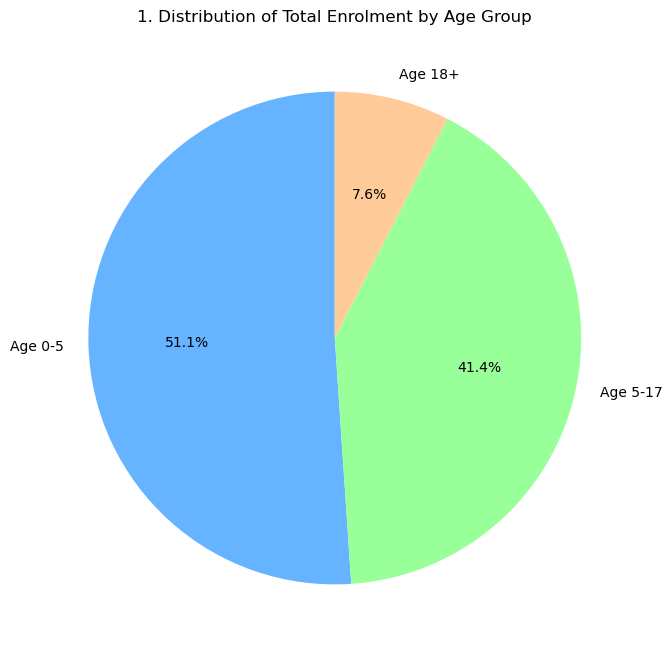

In [10]:
# --- 3. Graph Generation (Matplotlib/Pandas - Local Operation) ---

# Graph 1: Pie Chart - Total Enrolment by Age Group
plt.figure(figsize=(8, 8))
plt.pie(age_group_pd['Total_Enrolment'], labels=age_group_pd['Age_Group'], 
        autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#99ff99','#ffcc99'])
plt.title('1. Distribution of Total Enrolment by Age Group')
plt.savefig('pyspark_graph_1_age_group_pie.png')
plt.show()  # Display inline


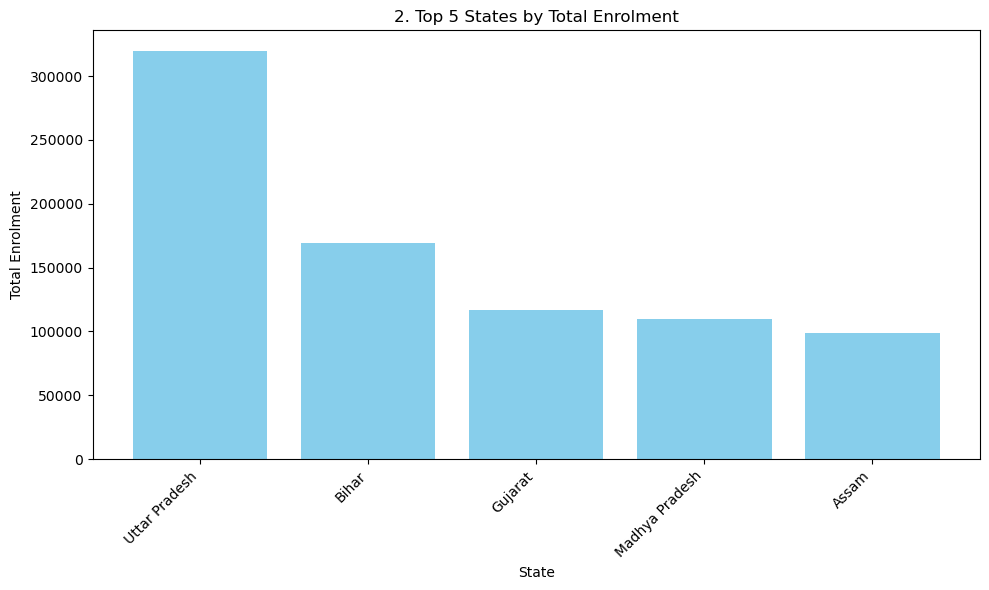

In [11]:
# Graph 2: Bar Chart - Top 5 States by Total Enrolment
plt.figure(figsize=(10, 6))
plt.bar(top_states_pd['State'], top_states_pd['State_Total_Enrolment'], color='skyblue')
plt.xlabel('State')
plt.ylabel('Total Enrolment')
plt.title('2. Top 5 States by Total Enrolment')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('pyspark_graph_2_top_states_bar.png')
plt.show()

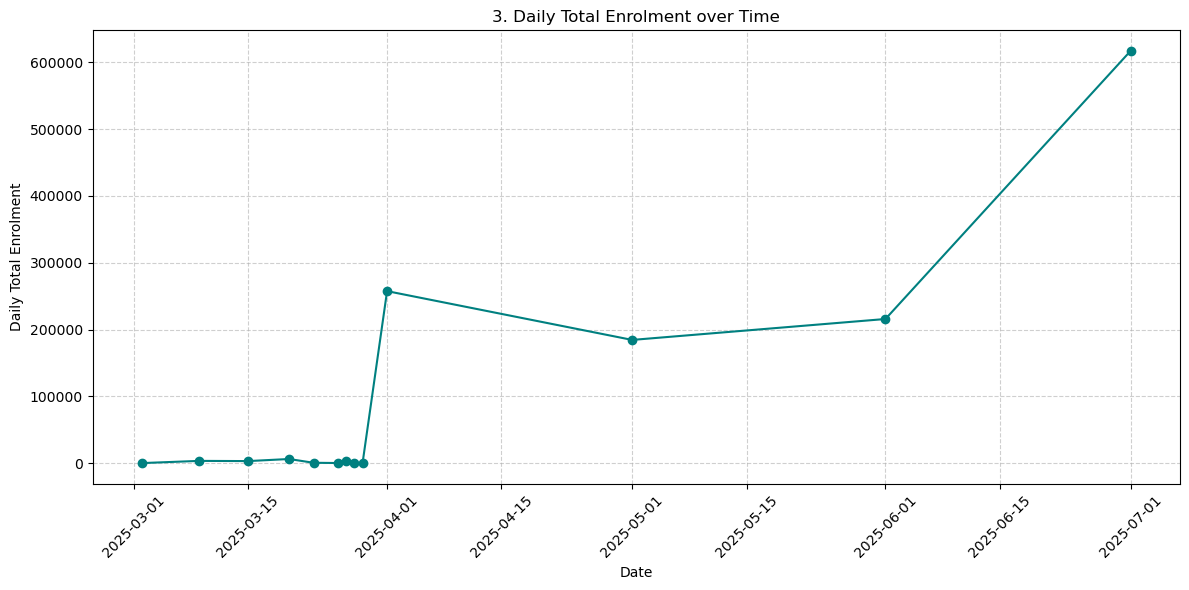

In [12]:
# Graph 3: Line Chart - Daily Total Enrolment over Time
plt.figure(figsize=(12, 6))
plt.plot(enrolment_by_date_pd['Parsed_Date'], enrolment_by_date_pd['Daily_Total_Enrolment'], 
         marker='o', linestyle='-', color='teal')
plt.xlabel('Date')
plt.ylabel('Daily Total Enrolment')
plt.title('3. Daily Total Enrolment over Time')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('pyspark_graph_3_daily_enrolment_line.png')
plt.show()


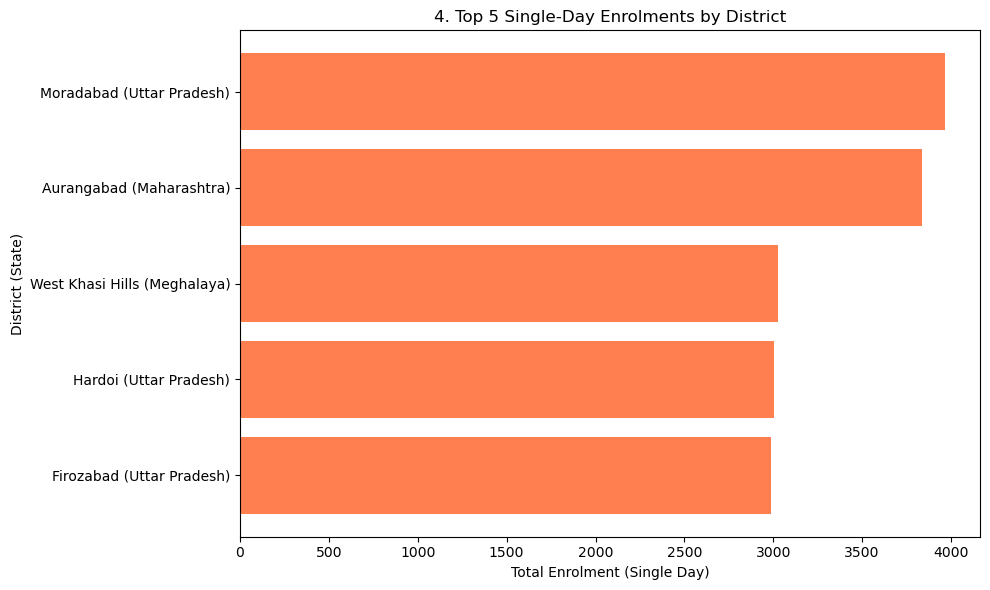

In [13]:
# Graph 4: Bar Chart - Top 5 Single-Day Enrolments by District
plt.figure(figsize=(10, 6))
top_districts_overall_pd = top_districts_overall_pd.sort_values(by='Total_Enrolment', ascending=True)
plt.barh(top_districts_overall_pd['Label'], top_districts_overall_pd['Total_Enrolment'], color='coral')
plt.xlabel('Total Enrolment (Single Day)')
plt.ylabel('District (State)')
plt.title('4. Top 5 Single-Day Enrolments by District')
plt.tight_layout()
plt.savefig('pyspark_graph_4_top_district_single_day_bar.png')
plt.show()

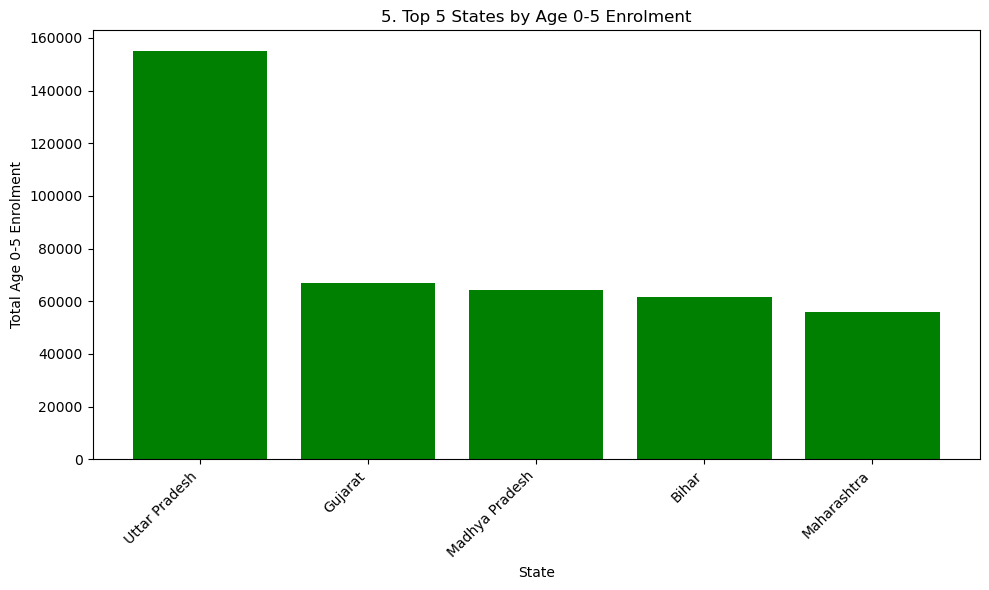

In [14]:
# Graph 5: Bar Chart - Top 5 States by Age 0-5 Enrolment
plt.figure(figsize=(10, 6))
plt.bar(top_5_age_0_5_states_pd['State'], top_5_age_0_5_states_pd['Age_0_5_Enrolment'], color='green')
plt.xlabel('State')
plt.ylabel('Total Age 0-5 Enrolment')
plt.title('5. Top 5 States by Age 0-5 Enrolment')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('pyspark_graph_5_top_states_age_0_5_bar.png')
plt.show()


In [15]:
# Stop the Spark session
spark.stop()
print("\nSpark session stopped. All tables printed and 5 graph files generated & displayed inline.")



Spark session stopped. All tables printed and 5 graph files generated & displayed inline.


In [16]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("EnrolmentAnalysis_Restarted").getOrCreate()
print("Spark Session restarted successfully.")


Spark Session restarted successfully.


In [17]:
# Stop the Spark session
spark.stop()
print("\nSpark session stopped. All tables printed and 5 graph files generated & displayed inline.")



Spark session stopped. All tables printed and 5 graph files generated & displayed inline.
